In [12]:
from ViolaJones import ViolaJones
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
from util import *
import skimage.io as io
from skimage.color import rgb2gray,rgb2hsv
import cv2
import commonfunctions as cf
from haar_utils import *

In [13]:
with open("Datasets/faces_cropped.pkl", 'rb') as f:
    data = pickle.load(f)
with open("Datasets/non-faces.pkl", 'rb') as f:
    data += pickle.load(f)
start_pos= 0
end_pos=2500
start_neg=5000
end_neg=5080
train_data=data[start_pos:end_pos]+data[start_neg:end_neg]
images = []
labels =[]
for tup in train_data:
    images.append(tup[0])
    labels.append(tup[1])

In [ ]:
featurespath="_"+str(start_pos)+"_"+str(end_pos)+"_"+str(start_neg)+"_"+str(end_neg)
clf = ViolaJones(layers=[40],featurespath="_"+str(start_pos)+"_"+str(end_pos)+"_"+str(start_neg)+"_"+str(end_neg))

clf.train(images, np.array(labels))  # X_f (optional, to speed-up training)
print("Training finished!")

# Save weights
print("\nSaving weights...")
clf.save("cvj_weights_data_set_2"+featurespath+clf.layers)
print("Weights saved!")

In [3]:
def evaluate(clf, X, y):
    metrics = {}
    true_positive, true_negative = 0, 0  # Correct
    false_positive, false_negative = 0, 0  # Incorrect

    for i in range(len(y)):
        prediction = clf.classify(X[i])
        if prediction == y[i]:  # Correct
            if prediction == 1:  # Face
                true_positive += 1
            else:  # No-face
                true_negative += 1
        else:  # Incorrect

            if prediction == 1:  # Face
                false_positive += 1
            else:  # No-face
                false_negative += 1

    metrics['true_positive'] = true_positive
    metrics['true_negative'] = true_negative
    metrics['false_positive'] = false_positive
    metrics['false_negative'] = false_negative

    metrics['accuracy'] = (true_positive + true_negative)/(true_positive+false_negative+true_negative+false_positive)
    metrics['precision'] = true_positive / (true_positive+false_positive)
    metrics['recall'] = true_positive / (true_positive+false_negative)  
    metrics['specifity'] = true_negative/(true_negative+false_positive)
    metrics['f1'] = (2.0 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

    return metrics


In [6]:
def test(clf, name="test"):
    # Load test set
    print("\nLoading {}...".format(name))
    with open("Datasets/test_faces_cropped.pkl", 'rb') as f:
        test = pickle.load(f)
    with open("Datasets/non-faces.pkl", 'rb') as f:
        test2 = pickle.load(f)
    test = test + test2[1501:]
#     test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
#     test = [(cv2.resize(test , (19,19)) , 1)]
#     io.imshow(test[0][0])
    #np.random.shuffle(test)
    images_test = []
    labels_test =[]
    for tup in test:
        images_test.append(tup[0])
        labels_test.append(tup[1])
    # Evaluate
    print("\nEvaluating...")
    metrics = evaluate(clf, images_test, np.array(labels_test))

    print("Metrics: [{}]".format(name))
    counter = 0
    for k, v in metrics.items():
        counter += 1
        if counter <= 4:
            print("\t- {}: {:,}".format(k, v))
        else:
            print("\t- {}: {:.3f}".format(k, v))

In [18]:
test(ViolaJones.load("weights/cvj_weights_data_set_2_0_2000_5000_6500.pkl"))


Loading test...

Evaluating...
Metrics: [test]
	- true_positive: 6,594
	- true_negative: 5,682
	- false_positive: 82
	- false_negative: 467
	- accuracy: 0.957
	- precision: 0.988
	- recall: 0.934
	- specifity: 0.986
	- f1: 0.960


## Testing on some images

In [2]:
def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

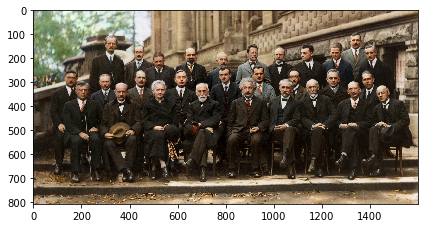

In [3]:
## reading the image and prprocess it
scientists= io.imread("solvay-conference.jpg")
io.imshow(scientists)

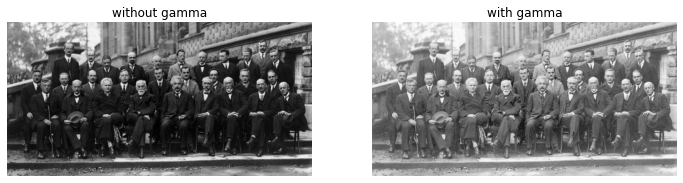

In [4]:
scientists_greyscale = cv2.cvtColor(scientists, cv2.COLOR_BGR2GRAY) /255
scientists_greyscale_enhanced = (gamma(scientists_greyscale) *255).astype(np.uint8)
cf.show_images([scientists_greyscale,scientists_greyscale_enhanced], ["without gamma", "with gamma"])

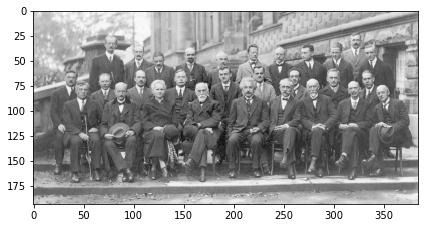

In [5]:
import imutils
## according to paper, image should be resized to (384, 288)
## using imutils is to maintain its aspect ratio
final_image = imutils.resize(scientists_greyscale_enhanced , width=384)
io.imshow(final_image)

In [6]:
from haar_utils import *
window_size=19
rows, cols = final_image.shape
half_window = window_size // 2
# loading the viola-jones objectclfViolaJones.load("cvj_weights_data_set_2_0_2000_4000_5600_1_10_allftres.pkl")
clf_test=ViolaJones.load("weights/cvj_weights_data_set_2_0_2000_5000_6500.pkl")
clf_test.clfs

In [7]:
def get_faces(half_window,rows,cols,final_image,clf_test, shift=1):
    face_positions=[]
    for row in range(half_window + 1, rows - half_window,shift):
        for col in range(half_window + 1, cols - half_window,shift):
            # walking through the image with our window size
            if(row+half_window<=final_image.shape[0] and col+half_window+1<=final_image.shape[1]
              and row-half_window-1>=0 and col-half_window-1>=0):
                window = final_image[row-half_window-1:row+half_window+1, col-half_window-1:col+half_window+1]
            else:
                continue

            probably_face = clf_test.classify(window)
            if probably_face < .5:
                continue
            face_positions.append((row, col))
    return face_positions
face_positions_scientists= get_faces(half_window,rows,cols,final_image,clf_test,4)

In [8]:
print(f'Found {len(face_positions_scientists)} candidates')

Found 64 candidates


In [9]:
face_positions_suppressed= non_maximum_supression(face_positions_scientists, half_window, threshold=0.01)
print(len(face_positions_suppressed))

30


In [10]:
## to draw boxes in the original image
def render_boxex(image, regions, scale_w=1,scale_h=1, half_window=half_window) -> Image.Image:
    canvas = np.copy(image)
    for row, col in regions:
        row=scale_h
        col=scale_w
        if(row-half_window-1>=0 and row+half_window<=image.shape[0]
          and col-half_window-1>=0):
            canvas[row-half_window-1:row+half_window, col-half_window-1, :] = [255., 0., 0.]
        if(row-half_window-1>=0 and row+half_window<=image.shape[0]
          and col+half_window-1<=image.shape[1]):
            canvas[row-half_window-1:row+half_window, col+half_window-1, :] = [255., 0., 0.]
        if(row-half_window-1>=0 
          and col-half_window-1>=0 and col+half_window<=image.shape[1]):
            canvas[row-half_window-1, col-half_window-1:col+half_window, :] = [255., 0., 0.]
        if(row+half_window-1<=image.shape[0]
          and col-half_window-1>=0 and col+half_window<=image.shape[1]):
            canvas[row+half_window-1, col-half_window-1:col+half_window, :] = [255., 0., 0.]
    return canvas

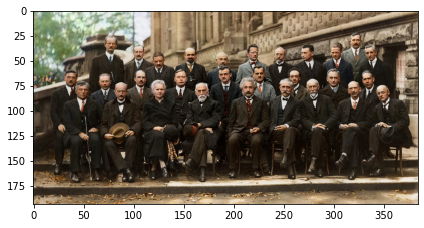

In [11]:
scientists_resized = imutils.resize(scientists , width=384)

io.imshow(render_boxex(scientists_resized, face_positions_suppressed))

## Testing RealTime (Using Video)

In [ ]:
vid = cv2.VideoCapture(0)

while(True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()


    # Display the resulting frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) /255
    gray_enhanced = (gamma(gray) *255).astype(np.uint8)
    img = imutils.resize(gray_enhanced ,width =150)
    scale_w= frame.shape[0] // img.shape[0]
    scale_h= frame.shape[1] // img.shape[1]
    positions = get_faces(half_window,rows,cols,img,clf_test,4)
    positions =  non_maximum_supression(positions, half_window, threshold=0.00000001)
    print(positions)
    img = render_boxex(frame , positions,scale_w,scale_h)
    cv2.imshow('frame', img)
    io.imshow(img)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()
